In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pyvinecopulib as pv
import statsmodels.api as sm
import statsmodels.formula.api as smf
from arch import arch_model

In [2]:
def download_data(tickers, start, end):
    data = yf.download(tickers=tickers, start = start, end = end)["Adj Close"]
    data = pd.DataFrame(
        np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns
    )
    data = data.dropna(axis=0)
    return data

In [3]:
data = download_data(tickers=["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2018-12-31")

[*********************100%%**********************]  6 of 6 completed


In [8]:
testmodel = arch_model(data['AAPL'], vol="Garch", p=1, o=0, q=1, dist="t", mean="Constant").fit(disp='off')

In [92]:
from statsmodels.distributions.copula.api import StudentTCopula
copulatest = GaussianCopula(k_dim=6)
copulatest = StudentTCopula(k_dim=6, df=3)

In [93]:
copulatest.fit_corr_param(data=data)

array([[1.        , 0.28863513, 0.24993151, 0.25340446, 0.49698159,
        0.19374204],
       [0.28863513, 1.        , 0.68277114, 0.61353648, 0.34336514,
        0.49247003],
       [0.24993151, 0.68277114, 1.        , 0.57345231, 0.31674147,
        0.42236478],
       [0.25340446, 0.61353648, 0.57345231, 1.        , 0.31976564,
        0.4792331 ],
       [0.49698159, 0.34336514, 0.31674147, 0.31976564, 1.        ,
        0.26966558],
       [0.19374204, 0.49247003, 0.42236478, 0.4792331 , 0.26966558,
        1.        ]])

In [94]:
copulatest.args

(array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]]),
 3)

In [95]:
copulatest.df

3

In [97]:
copulatest.rvs(10)

array([[0.27520985, 0.24457596, 0.47014537, 0.79130002, 0.07199943,
        0.74621415],
       [0.34549596, 0.48578406, 0.78218922, 0.73547385, 0.210436  ,
        0.53824789],
       [0.54663426, 0.09520711, 0.46367417, 0.1653281 , 0.34065599,
        0.16218688],
       [0.4672907 , 0.12653388, 0.55721739, 0.92702504, 0.34324777,
        0.16770321],
       [0.31512727, 0.84507054, 0.2327407 , 0.34879163, 0.58925697,
        0.37887274],
       [0.45966024, 0.42282712, 0.66464992, 0.73473216, 0.57529285,
        0.31960017],
       [0.96549409, 0.37178087, 0.06104914, 0.82554726, 0.98083074,
        0.74728863],
       [0.58630471, 0.32367762, 0.24682766, 0.36439776, 0.94362485,
        0.89932945],
       [0.46908782, 0.66239994, 0.69475551, 0.78832748, 0.37875439,
        0.47533926],
       [0.47094158, 0.71223368, 0.17823287, 0.42814198, 0.10175129,
        0.13340076]])

In [101]:
from statsmodels.distributions.copula.api import GaussianCopula, StudentTCopula
def predict_next_period(data, VaR_level):
    garch_models = {}
    for column in data.columns:
        garch_models[column] = dict()
        am = arch_model(data[column], vol="Garch", p=1, o=0, q=1, dist="t", mean="constant").fit(disp='off')
        z = am.resid/am.conditional_volatility 
        u = am.model.distribution.cdf(z, parameters=am.params['nu'])
        garch_models[column]['arch_model'] = am
        garch_models[column]['z'] = z
        garch_models[column]['u'] = u

    u_data = pd.DataFrame()
    for ticker in data.columns:
        u_series = pd.Series(garch_models[ticker]['u'], name=ticker)
        u_data = pd.concat([u_data, u_series], axis=1)

    copula = GaussianCopula(k_dim=data.shape[1])
    copula.fit_corr_param(u_data)
    u_sim = pd.DataFrame(copula.rvs(nobs=1000), columns=data.columns)

    for ticker in garch_models.keys():
        z_sim = garch_models[ticker]['arch_model'].model.distribution.ppf(u_sim[ticker], parameters=am.params['nu'])
        garch_models[ticker]['z_sim'] = z_sim
        params = garch_models[ticker]['arch_model'].params
        sigma_next_period = np.sqrt(params['omega'] + params['alpha[1]'] * np.square(data[ticker].iloc[-1]) + params['beta[1]'] * np.square(garch_models[ticker]['arch_model']._volatility[-1]))
        next_period_returns = pd.Series(params['mu'] + sigma_next_period * garch_models[ticker]['z_sim'], name=ticker).sort_values()
        garch_models[ticker]['sigma_next_period'] = sigma_next_period
        garch_models[ticker]['next_period_returns'] = next_period_returns

    VaR = np.mean([v['next_period_returns'].quantile(VaR_level) for v in garch_models.values()])
    
    return VaR

In [102]:
result = pd.DataFrame(columns=['Portfolio', 'VaR'])

In [103]:
for i in range(data.shape[0]-1500-1):
    start = i
    end = start + 1500
    temp_data = data.iloc[start:end]
    print("start: ", start)
    print("end: ", end)
    res = predict_next_period(data=temp_data, VaR_level=0.01)
    print(res)
    result.loc[end+1, 'VaR'] = res
    result.loc[end+1, 'Portfolio'] = np.mean(data.iloc[end+1,:])

start:  0
end:  1500
-5.549478471311146
start:  1
end:  1501
-5.672927935473091
start:  2
end:  1502
-5.930376449431694
start:  3
end:  1503
-5.709119573161705
start:  4
end:  1504
-5.756869537983037
start:  5
end:  1505
-5.642736370778109
start:  6
end:  1506
-5.311148835796577
start:  7
end:  1507
-5.446893724909351
start:  8
end:  1508
-5.299046509003536
start:  9
end:  1509
-5.214949614117793
start:  10
end:  1510
-4.9588779506538385
start:  11
end:  1511
-5.049640374173053
start:  12
end:  1512
-5.2022262170657285
start:  13
end:  1513
-5.011116201354484
start:  14
end:  1514
-5.096934639156838
start:  15
end:  1515
-5.128802309437687
start:  16
end:  1516
-5.036774296806203
start:  17
end:  1517
-4.771335912089096
start:  18
end:  1518
-4.802315097205206
start:  19
end:  1519
-4.699130548883232
start:  20
end:  1520
-4.654693004441721
start:  21
end:  1521
-4.668788303260418
start:  22
end:  1522
-4.6017638179175995
start:  23
end:  1523
-4.746152850226243
start:  24
end:  1524
-

<Axes: >

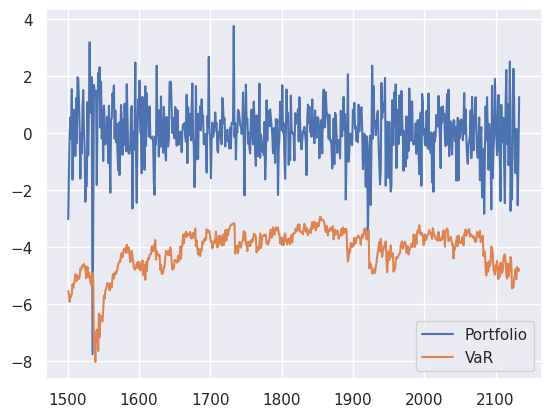

In [104]:
result.plot()

In [105]:
result.shape[0]*0.01

6.33

In [106]:
result[result['VaR']>result['Portfolio']]

,Portfolio,VaR
1535,-7.76606,-4.915778


<Axes: xlabel='Portfolio', ylabel='Density'>

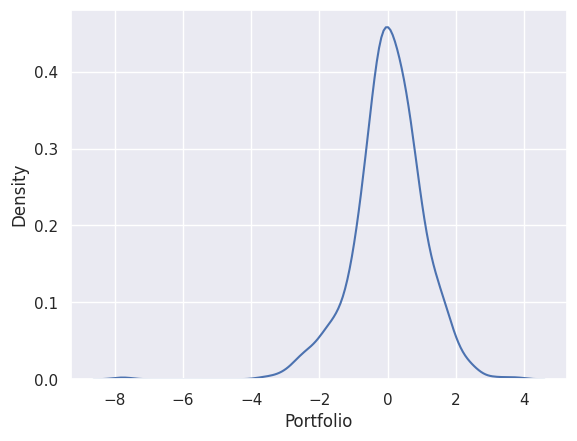

In [107]:
sns.kdeplot(result['Portfolio'])

$x_t = \mu + \sigma_t \epsilon_t\\
\sigma_t² = a_0 + a_1 x_{t-1}² + b_1 \sigma_{t-1}²$

epsilon = copula werte